**ИТОГОВАЯ АТТЕСТАЦИОННАЯ РАБОТА**  
по дополнительной профессиональной программе профессиональной переподготовки  
**Аналитик данных**  
Выполнил: Казанская Екатерина Дмитриевна  

  


**Тема: "Выделение портретов заемщиков банка"**

**Аналитическая задача** — провести анализ данных с целью выделения портретов заемщиков по каждой группе целевого признака.

**Примерный план исследования**

Шаг 1. Загрузка данных;

Шаг 2. Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

Шаг 3. Добавление новых признаков:
- для каждого клиента рассчитайте его возраст на настоящий момент времени (на 2025 год);

Шаг 4. Исследовательский анализ данных
- в разрезе значений целевого признака (`Дисциплина клиентов без просрочки по кредиту`) исследовать распределения числовых и категориальных признаков;
- в разрезе значений целевого признака составить портреты клиентов платежной системы.

# Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

# Блок пользовательских функций

In [ ]:
def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

# Шаг 1. Загрузка и ознакомление с данными

In [ ]:
# Загрузка данных
df = pd.read_csv('/content/dataset_segment_bank.csv')
df.head(10)

,Идентификатор,Дата рождения,Дисциплина клиентов без просрочки по кредиту,Количество переводов,Тип переводов,География переводов,География телефона,Сумма перевода,Максимальная сумма перевода,Средняя сумма перевода,Полная сумма перевода,"Канал, через который пришел клиент",Оператор связи,Пол
0,1493553,1981-05-08,BAD,17.0,2.0,77.0,77.0,371600.00,265000.0,21858.8235,371600.00,Стойка,NaN,Ж
1,8130758,1979-03-06,BAD,4.0,2.0,77.0,77.0,137574.00,135000.0,34393.5000,137574.00,Стойка,NaN,М
2,1782539,1957-04-29,BAD,3.0,2.0,77.0,77.0,175150.00,135000.0,58383.3333,175150.00,Стойка,МегаФон,М
3,12410720,1977-08-05,BAD,3.0,2.0,77.0,77.0,50250.00,50000.0,16750.0000,50250.00,Стойка,NaN,М
4,21309736,1978-08-15,GOOD,5.0,69.0,77.0,77.0,215920.14,135000.0,43184.0280,215920.14,Стойка,NaN,М
5,11343857,1983-05-06,BAD,2.0,1.0,77.0,77.0,50150.00,50000.0,25075.0000,50150.00,Стойка,NaN,Ж
6,5383517,1972-02-01,BAD,4.0,2.0,77.0,77.0,204150.00,200000.0,51037.5000,204150.00,Стойка,NaN,Ж
7,3882794,1979-05-20,BAD,15.0,5.0,77.0,77.0,538300.00,400000.0,35886.6666,538300.00,Стойка,NaN,Ж
8,7119607,1969-08-18,BAD,4.0,2.0,77.0,77.0,135335.00,135000.0,33833.7500,135335.00,Офис,NaN,Ж
9,7369177,1964-12-17,BAD,9.0,2.0,77.0,77.0,62310.00,38000.0,6923.3333,62310.00,Офис,Вымпел-Коммуникации,Ж


In [ ]:
# просмотр информации о типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50224 entries, 0 to 50223
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Идентификатор                                 50224 non-null  int64  
 1   Дата рождения                                 50224 non-null  object 
 2   Дисциплина клиентов без просрочки по кредиту  50223 non-null  object 
 3   Количество переводов                          50158 non-null  float64
 4   Тип переводов                                 50191 non-null  float64
 5   География переводов                           50191 non-null  float64
 6   География телефона                            48324 non-null  float64
 7   Сумма перевода                                50158 non-null  float64
 8   Максимальная сумма перевода                   50158 non-null  float64
 9   Средняя сумма перевода                        50158 non-null 

In [ ]:
# просмотр описательных статистик
perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df.describe(percentiles=perc)

,Идентификатор,Количество переводов,Тип переводов,География переводов,География телефона,Сумма перевода,Максимальная сумма перевода,Средняя сумма перевода,Полная сумма перевода
count,5.022400e+04,50158.000000,50191.000000,50191.000000,48324.000000,5.015800e+04,5.015800e+04,50158.000000,5.015800e+04
mean,1.097869e+07,17.290821,13.186328,110.217888,58.161183,2.995784e+05,1.676934e+05,34478.895504,2.995784e+05
std,5.760869e+06,34.801316,22.298265,4969.776700,22.708184,4.527366e+05,1.410307e+05,43548.644155,4.527366e+05
min,1.400402e+06,1.000000,-1.000000,0.000000,0.000000,3.000000e+01,3.000000e+01,30.000000,3.000000e+01
1%,1.552898e+06,1.000000,0.000000,2.000000,2.000000,2.380555e+04,1.041879e+04,2318.792510,2.380555e+04
5%,2.228634e+06,2.000000,2.000000,13.000000,10.000000,4.000000e+04,3.000000e+04,4381.164050,4.000000e+04
25%,6.397864e+06,4.000000,2.000000,48.000000,40.000000,9.225300e+04,5.500000e+04,10108.333300,9.225300e+04
50%,1.133596e+07,9.000000,5.000000,73.000000,66.000000,1.877303e+05,1.200000e+05,19831.931800,1.877303e+05
75%,1.444163e+07,18.000000,6.000000,77.000000,77.000000,3.831000e+05,2.350000e+05,41650.750000,3.831000e+05
95%,2.209581e+07,58.000000,69.000000,78.000000,78.000000,8.242231e+05,4.900000e+05,113383.333300,8.242231e+05


In [ ]:
# сравним значения в признаках  'Сумма перевода' и 'Полная сумма перевода'
df.loc[~(df['Сумма перевода'] == df['Полная сумма перевода'])].info()
# во всех строках, кроме 66(из 41497) значения совпадают, можем удалить один из этих столбцов

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 50158 to 50223
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Идентификатор                                 66 non-null     int64  
 1   Дата рождения                                 66 non-null     object 
 2   Дисциплина клиентов без просрочки по кредиту  66 non-null     object 
 3   Количество переводов                          0 non-null      float64
 4   Тип переводов                                 33 non-null     float64
 5   География переводов                           33 non-null     float64
 6   География телефона                            28 non-null     float64
 7   Сумма перевода                                0 non-null      float64
 8   Максимальная сумма перевода                   0 non-null      float64
 9   Средняя сумма перевода                        0 non-null      flo

In [ ]:
# посмотрим уникальные значения в признаках с типом 'object'
for col in df.select_dtypes('object').columns:
    print(f'Уникальные значения признака <<<{col}>>>')
    print(df[col].unique())
    print('-'*10)
    print()

Уникальные значения признака <<<Дата рождения>>>
['1981-05-08' '1979-03-06' '1957-04-29' ... '1965-11-12' '1990-06-12'
 '1975-04-01']
----------

Уникальные значения признака <<<Дисциплина клиентов без просрочки по кредиту>>>
['BAD' 'GOOD' 'MIDDLE' nan]
----------

Уникальные значения признака <<<Канал, через который пришел клиент>>>
['Стойка' 'Офис' 'Партнер' nan]
----------

Уникальные значения признака <<<Оператор связи>>>
[nan 'МегаФон' 'Вымпел-Коммуникации' 'Мобильные ТелеСистемы'
 'Вотек Мобайл' 'Нижегородская сотовая связь' 'МобильныеТелеСистемы'
 'Санкт-Петербург Телеком' 'Телеком Евразия' 'Кемеровская Мобильная Связь'
 'Средневолжская межрегиональная ассоциация радиотел'
 'Ростовская Сотовая Связь' 'Ростелеком' 'Смоленская Сотовая Связь'
 'Челябинская Сотовая Связь' 'ЕКАТЕРИНБУРГ-2000' 'Телесет Лтд.'
 'Сотовая Связь Удмуртии' 'Персональные Системы Связи в Регионе'
 'Белгородская Сотовая Связь' 'Сибирская Сотовая Связь' 'Волгоград-GSM'
 'Ниж-ская сот.связь' 'Енисейтелеком' 'Нов

## Выводы

Данные загружены корректно;  
обнаружены следующие особенности данных:

|Признак|Комментарий|
|--:|:--|
|`all`|сделать лаконичные заголовки|
|`География телефона`,`Канал, через который пришел клиент`,|в признаках есть пропуски|
|`Оператор связи`,`Пол` |в признаках есть пропуски|
|`Сумма перевода`,`Полная сумма перевода`|значения в признаках совпадают, можно удалить дублир. признак|
|`Средняя сумма перевода`|производное от признаков `Количество переводов` и `Полная сумма перевода`|
|`Дата рождения`|поменять тип данных на дату|
|`Тип переводов`|есть отрицательное значение, проверить|
||имеются текстовые признаки.Проверить уник значения|
|Количество переводов|Подозрение на аномалию|
|||


# Шаг 2. Первичная обработка данных (при необходимости)

## Удаление дублирующихся столбцов

In [ ]:
# предобработка: удаление дублирующихся столбцов (если имеются)
lst_var_drop = ['Средняя сумма перевода',
                'Полная сумма перевода']
df.drop(columns = lst_var_drop,
        inplace=True)

## Корректировка заголовков

In [ ]:
# предобработка: переименование столбцов
# приведение к нижнему регистру
df.columns = df.columns.str.lower()

df.rename(columns={'дисциплина клиентов без просрочки по кредиту': 'дисциплина клиента',
                   'канал, через который пришел клиент': 'канал клиента',
                   'максимальная сумма перевода': 'макс сумма перевода'
                   },
          inplace=True)
# замена пробелов на символ _
df.columns = ['_'.join(col.split()) for col in df.columns]

## Предобработка данных: корректировка типов

In [ ]:
# предобработка: скорректировать типы признаков;
df = df.astype({'дата_рождения': 'datetime64[s]'},
           errors = 'ignore')

## Предобработка данных: поиск дублей

In [ ]:
# проверить наличие дублирующихся записей;
df.duplicated().sum()
# видим, что есть 575 дублирующихся строк

np.int64(575)

In [ ]:
# просмотр дублирующихся записей
df.loc[df.duplicated()]

,идентификатор,дата_рождения,дисциплина_клиента,количество_переводов,тип_переводов,география_переводов,география_телефона,сумма_перевода,макс_сумма_перевода,канал_клиента,оператор_связи,пол
285,13429088,1984-09-12,MIDDLE,89.0,2.0,77.0,33.0,573174.03,25950.0,Партнер,Вотек Мобайл,М
334,13429088,1984-09-12,MIDDLE,89.0,2.0,77.0,33.0,573174.03,25950.0,Партнер,Вотек Мобайл,М
459,17591794,1974-09-28,MIDDLE,22.0,5.0,77.0,NaN,78746.00,10200.0,Партнер,Мобильные ТелеСистемы,М
466,17591794,1974-09-28,MIDDLE,22.0,5.0,77.0,NaN,78746.00,10200.0,Партнер,Мобильные ТелеСистемы,М
528,4872767,1968-02-18,BAD,13.0,2.0,77.0,77.0,316064.16,150000.0,Стойка,NaN,М
...,...,...,...,...,...,...,...,...,...,...,...,...
50149,8551974,1979-12-02,GOOD,471.0,16.0,77.0,23.0,2029892.53,30000.0,Партнер,Вымпел-Коммуникации,М
50150,8551974,1979-12-02,GOOD,471.0,16.0,77.0,23.0,2029892.53,30000.0,Партнер,Вымпел-Коммуникации,М
50151,8551974,1979-12-02,GOOD,471.0,16.0,77.0,23.0,2029892.53,30000.0,Партнер,Вымпел-Коммуникации,М
50152,8551974,1979-12-02,GOOD,471.0,16.0,77.0,23.0,2029892.53,30000.0,Партнер,Вымпел-Коммуникации,М


In [ ]:
# поиск дублей без одного признака - 'идентификатор' если идентификаторы разные
df.drop(columns='идентификатор').duplicated().sum()

np.int64(575)

In [ ]:
# удаление дублирующихся записей
df.drop_duplicates(keep='last',
                   inplace=True  #keep='last' оставляет последнюю запись
                    )

In [ ]:
# проверка что дубли удалены
df.duplicated().sum()

np.int64(0)

## Предобработка: поиск и обработка аномальных значений

In [ ]:
# проверить наличие аномальных значений;

In [ ]:
# список непрерывных признаков
lst_var_cont = ['количество_переводов','сумма_перевода', 'макс_сумма_перевода']

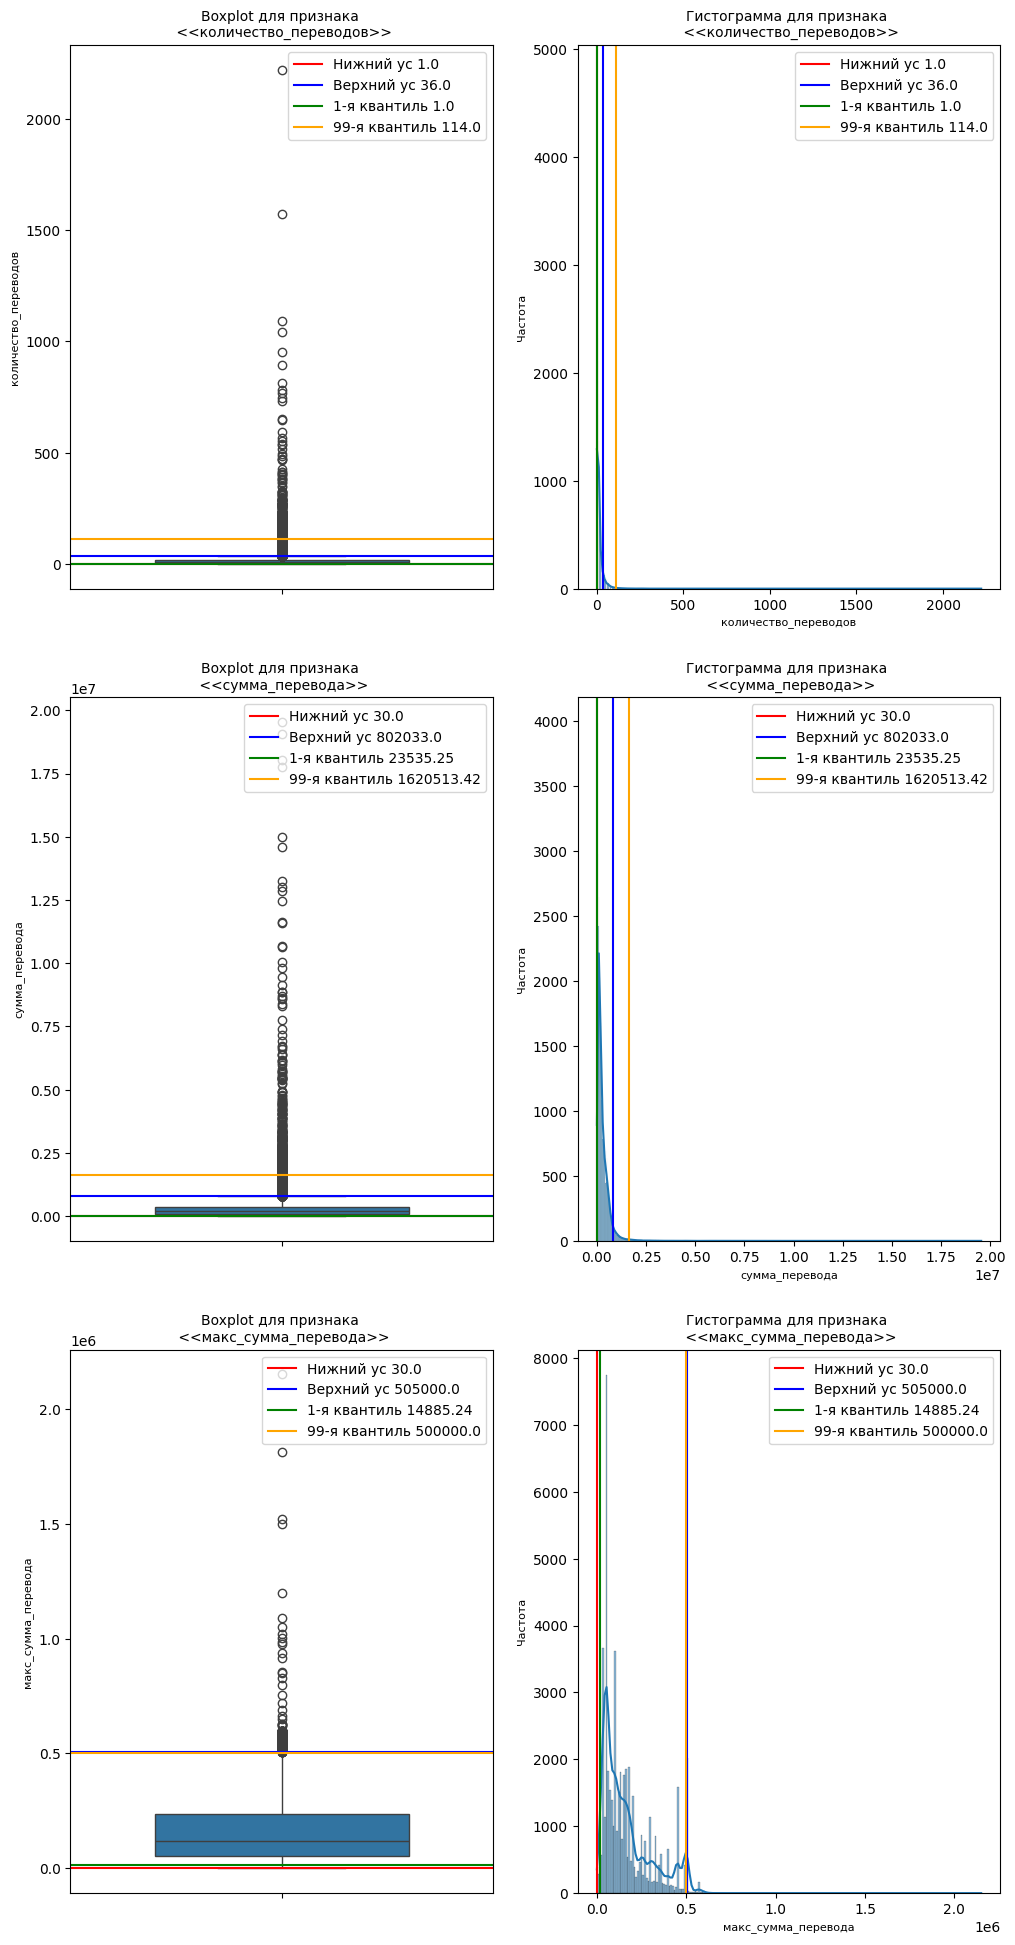

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (12, 24))

for index, col in enumerate(lst_var_cont): #перебираем в цикле заголовки признаков `col` и сразу же генерируем номер рисунка `index`
    plt.subplot(3, 2, 2*index + 1) #задаем рисунок с нужным нечетным номером (нумерация начинается с 1)
    ax = sns.boxplot(y = df[col], width=0.6) #рисуем ящик
    plt.title(f'Boxplot для признака \n <<{col}>>', fontsize = 10) #заголовок рисунка
    plt.ylabel(f'{col}', fontsize = 8) #подпись оси ординат
    plt.xlabel('', fontsize = 8) #подпись оси абцисс
    value_low, value_upper = calc_boxplot(df[col])
        #считаем 1 и 99 квантили
    per_1 = np.percentile(df[col].dropna(), 1)
    per_99 = np.percentile(df[col].dropna(), 99)
    plt.axhline(value_low, #значение координаты по оси ординат -- горизонтальная линия имеет координаты (0, value_low)
                color = 'red', # цвет линии
                label = 'Нижний ус {}'.format(np.round(value_low,2)) #текст для легенды -- отображаем значение уса, округленное до 2 знаков
                )
    plt.axhline(value_upper, #значение координаты по оси ординат -- горизонтальная линия имеет координаты (0, value_upper)
                color = 'blue', # цвет линии
                label = 'Верхний ус {}'.format(np.round(value_upper,2)) #текст для легенды -- отображаем значение уса, округленное до 2 знаков
                )

    plt.axhline(per_1, #значение координаты по оси ординат -- вертикальная линия имеет координаты (0, per_1)
                color = 'green', # цвет линии
                label = '1-я квантиль {}'.format(np.round(per_1,2)) #текст для легенды -- отображаем значение квантиля, округленное до 2 знаков
                )
    plt.axhline(per_99, #значение координаты по оси абцисс -- вертикальная линия имеет координаты (0, per_99)
                color = 'orange', # цвет линии
                label = '99-я квантиль {}'.format(np.round(per_99,2)) #текст для легенды -- отображаем значение квантиля, округленное до 2 знаков
                )

    plt.legend(loc='upper right') #отображаем легенду, принудительно размещая ее в правом верхнем углу

    #четные рисунки -- рисуем гистограммы и плотности
    plt.subplot(3, 2, 2*index + 2)
    ax = sns.histplot(df[col], #признак
                      kde = True #для рисования функции плотности
                      )


    #вначале рисуем усы на плотности в виде вертикальных линий -- метод axvline()

    plt.axvline(value_low, #значение координаты по оси ординат -- горизонтальная линия имеет координаты (0, value_low)
                color = 'red', # цвет линии
                label = 'Нижний ус {}'.format(np.round(value_low,2)) #текст для легенды -- отображаем значение уса, округленное до 2 знаков
                )
    plt.axvline(value_upper, #значение координаты по оси ординат -- горизонтальная линия имеет координаты (0, value_upper)
                color = 'blue', # цвет линии
                label = 'Верхний ус {}'.format(np.round(value_upper,2)) #текст для легенды -- отображаем значение уса, округленное до 2 знаков
                )

    plt.legend(loc='upper right') #отображаем легенду, принудительно размещая ее в правом верхнем углу

    #рисуем квантили

    plt.axvline(per_1, #значение координаты по оси ординат -- вертикальная линия имеет координаты (0, per_1)
                color = 'green', # цвет линии
                label = '1-я квантиль {}'.format(np.round(per_1,2)) #текст для легенды -- отображаем значение квантиля, округленное до 2 знаков
                )
    plt.axvline(per_99, #значение координаты по оси абцисс -- вертикальная линия имеет координаты (0, per_99)
                color = 'orange', # цвет линии
                label = '99-я квантиль {}'.format(np.round(per_99,2)) #текст для легенды -- отображаем значение квантиля, округленное до 2 знаков
                )

    plt.legend(loc='upper right') #отображаем легенду, принудительно размещая ее в правом верхнем углу
    plt.title(f'Гистограмма для признака \n <<{col}>>', fontsize = 10) #заголовок рисунка
    plt.ylabel('Частота', fontsize = 8) #подпись оси ординат
    plt.xlabel(f'{col}', fontsize = 8) #подпись оси абцисс

In [ ]:
lst_var_cont = ['количество_переводов','сумма_перевода', 'макс_сумма_перевода']

In [ ]:
# Проанализировав построенные графики, составим фильтр для отсечения аномальных значений.
# По всем трем признакам мы видим, что есть много верхних выбросов за пределами усов, эти значения и попадут в фильтр


var1_low, var1_high = calc_boxplot(df[lst_var_cont[0]])
var2_low, var2_high = calc_boxplot(df[lst_var_cont[1]])
var3_low, var3_high = calc_boxplot(df[lst_var_cont[2]])

# фильтр по значениям верхних усов
filtered = (
    (df['количество_переводов'] <= var1_high)
    & (df['сумма_перевода'] <= var2_high)
    & (df['макс_сумма_перевода'] <= var3_high)
)

# проверка
df_not_anomals = df[filtered].copy()


# процент потерянных данных

print(f"""В результате удаления аномальных наблюдений потеряно {(1-df_not_anomals.shape[0]/df.shape[0]):.2%}.
В датасете осталось {df_not_anomals.shape[0]} строк.""")

В результате удаления аномальных наблюдений потеряно 12.22%.
В датасете осталось 43582 строк.


In [ ]:
# df_not_anomals.info()
# просмотр описательных статистик для очищенного датасета
perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df_not_anomals.describe(percentiles=perc)

,идентификатор,дата_рождения,количество_переводов,тип_переводов,география_переводов,география_телефона,сумма_перевода,макс_сумма_перевода
count,4.358200e+04,43582,43582.000000,43582.000000,43582.000000,41807.000000,43582.000000,43582.000000
mean,1.141449e+07,1970-11-11 08:30:50,9.800996,14.137144,117.687623,57.938503,216825.000207,154875.505061
min,1.400402e+06,1940-04-04 00:00:00,1.000000,-1.000000,0.000000,0.000000,30.000000,30.000000
1%,1.642914e+06,1947-03-15 00:00:00,1.000000,0.000000,2.000000,2.000000,20396.200000,14000.000000
5%,2.542847e+06,1952-01-18 01:12:00,2.000000,2.000000,13.000000,10.000000,36950.000000,30000.000000
25%,7.204440e+06,1962-06-14 00:00:00,4.000000,2.000000,48.000000,40.000000,81324.950000,55000.000000
50%,1.197543e+07,1971-08-08 12:00:00,7.000000,5.000000,73.000000,66.000000,161900.000000,110000.000000
75%,1.454944e+07,1979-10-17 18:00:00,13.000000,6.000000,77.000000,77.000000,304500.000000,200000.000000
95%,2.207624e+07,1987-05-11 00:00:00,27.000000,69.000000,78.000000,78.000000,581100.000000,450000.000000
99%,2.599681e+07,1989-08-17 04:33:36,34.000000,69.000000,78.000000,78.000000,720815.498300,500000.000000


## Предобработка: обработка категориальных признаков

In [ ]:
# список категориальных признаков
lst_cat_vars = ['тип_переводов', 'география_переводов',
       'география_телефона','канал_клиента',
        'оператор_связи', 'пол']

In [ ]:
# посмотрим часто встречающиеся значения
for col in lst_cat_vars:
    print(f'------- Признак: {col} --------')
    print(df[col].value_counts())
    print('---------------')
    print('---------------')

------- Признак: тип_переводов --------
тип_переводов
 2.0     18673
 5.0     13778
 69.0     6527
 6.0      2542
 8.0      1991
 1.0      1633
 10.0     1549
 0.0       739
 12.0      468
 26.0      289
 32.0      253
 16.0      248
 37.0      220
 11.0      194
 45.0      157
 7.0       139
 44.0       62
 58.0       45
 3.0        30
 28.0       14
 21.0       14
 33.0        7
 29.0        6
 4.0         5
 23.0        5
 19.0        5
 55.0        3
 54.0        3
 17.0        3
 53.0        2
 59.0        2
 61.0        2
 34.0        2
 43.0        1
 67.0        1
 30.0        1
-1.0         1
 9.0         1
 49.0        1
Name: count, dtype: int64
---------------
---------------
------- Признак: география_переводов --------
география_переводов
77.0        19144
78.0         4140
61.0         2338
23.0         2113
66.0         1502
            ...  
75.0            2
498001.0        2
6.0             1
20.0            1
19.0            1
Name: count, Length: 74, dtype: int64
-

In [ ]:
# замена низкочастотных значений признака 'тип_переводов' на одно
limit_value = 100
filt1 = df_not_anomals['тип_переводов'].value_counts() <  limit_value
value_replace = list(df_not_anomals['тип_переводов'].value_counts().loc[filt1].index)
dct_value_replace = dict.fromkeys(value_replace, 'другие_типы_переводов')
df_not_anomals['тип_переводов'] = df_not_anomals['тип_переводов'].replace(dct_value_replace)

In [ ]:
# обработаем значения в признаке 'география_переводов',
# всем переводам, количество которых меньше 1000 присвоим значение 1000.00
df_not_anomals['география_переводов'] = df_not_anomals['география_переводов'].replace(
                            {k: '1000.0'
                            for k, v in df_not_anomals['география_переводов'].value_counts().items() if v < 1000}
)

In [ ]:
# обработаем значения в признаке 'география_телефона',
# всем переводам, количество которых меньше 1000 присвоим значение 1000.0
df_not_anomals['география_телефона'] = df_not_anomals['география_телефона'].replace(
                            {k: '1000.0'
                            for k, v in df_not_anomals['география_телефона'].value_counts().items() if v < 1000}
)

In [ ]:
# обработаем значения в признаке 'оператор_связи'
# поскольку наибольшее кол-во клиентов распределено по трем основным операторам,
# остальных операторов объединим в одну группу - прочие
values_to_replace = {'Мобильные ТелеСистемы' : 'МТС',
                     'МобильныеТелеСистемы' : 'МТС'}
df_not_anomals.replace(values_to_replace,
           inplace=True)

df_not_anomals['оператор_связи'] = df_not_anomals['оператор_связи'].replace(
                            {k: 'прочие_операторы'
                            for k, v in df_not_anomals['оператор_связи'].value_counts().items() if v < 10000}
)

## Предобработка: работа с пропущенными значениями

In [ ]:
# восстановить пропущенные значения;
# количество пропусков по признакам
print(f'Процент пропусков: {df_not_anomals.isna().sum().sum() / df.shape[0] * 100:.2f}%')
df_not_anomals.isna().sum().sum()
# видим небольшое количество пропусков (Процент пропусков: 5.67%) по некоторым признаков.
# Удалим соответствущие записи (строки), содержащие пропуски
df_not_anomals.dropna(inplace=True)

Процент пропусков: 4.86%


In [ ]:
df_not_anomals.isna().sum().sum()

np.int64(0)

## Выводы

Проведены следующие работы:
- были удалены дублирующиеся столбцы;
- скорректированы заголовки признаков;  
- скорректированы типы данных соответствующих столбцов;  
- удалены дублирующиеся записи;  
- на основе анализа распределений непрерыв признаков относительно значений нижней и верхней границ boxplot'а, а также 1-ой и 99-ой перцентилей составлен фильтр для выявления аномальных значений;  
- были заменены низкочастотные значения категориальных признаков;  
- набор содержал небольшое количество пропущенных значений, которые были удалены.





# Шаг 3. Добавление новых признаков:

In [ ]:
# для каждого клиента рассчитайте его возраст на настоящий момент времени (на 2025 год);

In [ ]:
# приводим столбец к datetime
df_not_anomals['дата_рождения'] = pd.to_datetime(df_not_anomals['дата_рождения'])

# текущая дата
today = pd.Timestamp('today').normalize()

# точный возраст
df_not_anomals['возраст_клиента'] = today.year - df_not_anomals['дата_рождения'].dt.year - (
    (today.month < df_not_anomals['дата_рождения'].dt.month) |
    ((today.month == df_not_anomals['дата_рождения'].dt.month) & (today.day < df_not_anomals['дата_рождения'].dt.day))
)

## Выводы

На этом этапе был добавлен новый признак `возраст_клиента`

# Шаг 4. Исследовательский анализ данных

In [ ]:
# в разрезе значений целевого признака (Дисциплина клиентов без просрочки по кредиту)
# исследовать распределения числовых и категориальных признаков;
# в разрезе значений целевого признака составить портреты клиентов платежной системы.

In [ ]:
# выделим непрерывные числовые и дискретные(категориальные) признаки

lst_var_cont=['количество_переводов', 'сумма_перевода', 'макс_сумма_перевода']

lst_var_disc=['дисциплина_клиента', 'тип_переводов', 'география_переводов',
              'география_телефона', 'канал_клиента', 'оператор_связи', 'пол',
              'возраст_клиента']

## Исследование распределения числовых признаков в разрезе значений целевого признака `Дисциплина клиентов без просрочки по кредиту`

In [ ]:
# рассчитаем оценки параметров среднего положения для непрерыв признаков в разрезе Дисциплины
df_not_anomals.groupby('дисциплина_клиента')[lst_var_cont].agg(['mean', 'median'])

количество_переводов        сумма_перевода              \
                                   mean median           mean      median   
дисциплина_клиента                                                          
BAD                            7.895300    5.0  188868.716386  130100.000   
GOOD                          10.492124    8.0  232061.479907  180600.000   
MIDDLE                        10.964418    9.0  220510.469479  163958.655   

                   макс_сумма_перевода            
                                  mean    median  
дисциплина_клиента                                
BAD                      145258.501649  100000.0  
GOOD                     162354.916299  120000.0  
MIDDLE                   152354.682752  105000.0

In [ ]:
# Промежуточные выводы
# Мы видим, что клиенты с хорошей и средней дисциплиной в среднем совершают больше переводов, чем клиенты с плохой.
# Суммы переводов у таких клиентов так же больше

In [ ]:
# Посмотрим количественное распределение клиентов по дисциплинам
df_not_anomals.groupby('дисциплина_клиента')['канал_клиента'].count().reset_index()

,дисциплина_клиента,канал_клиента
0,BAD,8042
1,GOOD,21775
2,MIDDLE,11382


In [ ]:
# Промежуточные выводы
# Больше всего клиентов с хорошей дисциплиной, со средней почти в 2 раза меньше, с плохой еще меньше чем со средней

In [ ]:
# посмотрим значение моды по показателям
for value in df_not_anomals['дисциплина_клиента'].unique():
    print(value)
    display(df_not_anomals[df_not_anomals['дисциплина_клиента'] == value][lst_var_cont].mode())

BAD


,количество_переводов,сумма_перевода,макс_сумма_перевода
0,3.0,30100.0,50000.0


MIDDLE


,количество_переводов,сумма_перевода,макс_сумма_перевода
0,3.0,30000.0,50000.0


GOOD


,количество_переводов,сумма_перевода,макс_сумма_перевода
0,3.0,50150.0,50000.0


In [ ]:
# Промежуточные выводы
# в разрезе по дисциплинам видно, что наиболее часто у клиентов с BAD дисциплиной встречаются переводы по 30100р(3 раза),
# у клиентов с MIDDLE дисциплиной также встречаются 3 раза переводы по 30000р,
# у клиентов с GOOD дисциплиной тоже 3 раза встречаются переводы с суммой 50000р

In [ ]:
# Посмотрим дисциплину клиента по каналам прихода: Офис	Партнер	Стойка
df_count = (pd.pivot_table(data = df_not_anomals,
               index='дисциплина_клиента',
               columns='канал_клиента',
               values='идентификатор',
               aggfunc='count')
             .reset_index()  #сброс индекса
            )
df_count

канал_клиента,дисциплина_клиента,Офис,Партнер,Стойка
0,BAD,3182,4069,791
1,GOOD,11514,8506,1755
2,MIDDLE,5268,5144,970


In [ ]:
# Промежуточные выводы
# в цифровом выражении непонятно, есть ли разница, посчитаем в процентном соотношении

In [ ]:
df_count_clients = df_not_anomals.groupby('канал_клиента')['идентификатор'].count()
df_count_clients

,идентификатор
канал_клиента,
Офис,19964
Партнер,17719
Стойка,3516


In [ ]:
df_not_anomals.groupby('дисциплина_клиента')['канал_клиента'].count().reset_index()

,дисциплина_клиента,канал_клиента
0,BAD,8042
1,GOOD,21775
2,MIDDLE,11382


In [ ]:
for col in ['Офис', 'Партнер','Стойка']:
    df_count[col+'_доля'] = np.round(df_count[col] / df_count_clients.loc[col]*100,2)

In [ ]:
df_count

канал_клиента,дисциплина_клиента,Офис,Партнер,Стойка,Офис_доля,Партнер_доля,Стойка_доля
0,BAD,3182,4069,791,15.94,22.96,22.50
1,GOOD,11514,8506,1755,57.67,48.00,49.91
2,MIDDLE,5268,5144,970,26.39,29.03,27.59


In [ ]:
# Промежуточные выводы
# в процентном соотношении нет ярко выраженной тенденции прихода 'хорошего',
# 'среднего' или 'плохого' клиента через определенный канал

In [ ]:
# Посмотрим распределения по графикам

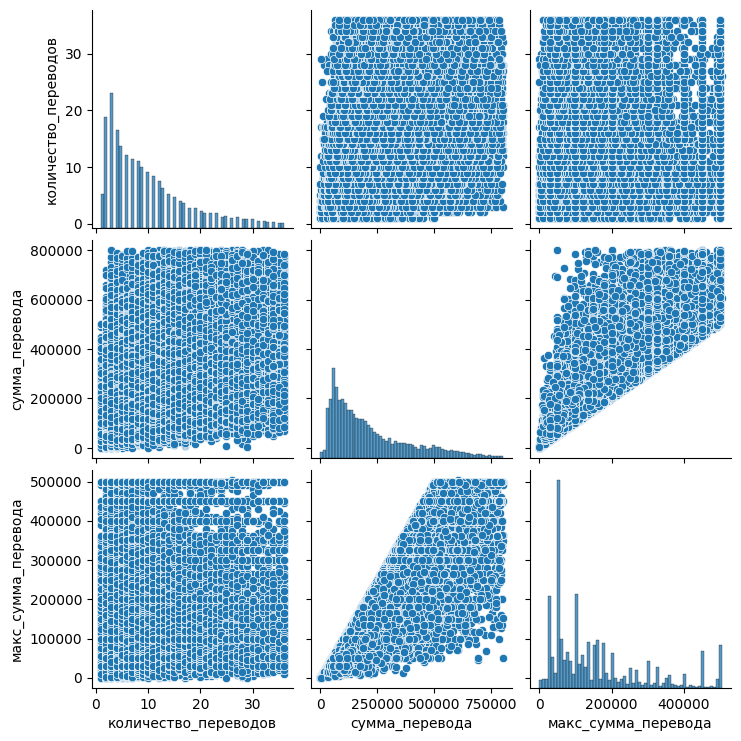

In [ ]:
#  диаграмма рассеивания
sns.pairplot(df_not_anomals[lst_var_cont])

In [ ]:
# По диаграмме рассеивания видим, что сумма перевода и максимальная сумма перевода в прямой корреляции

/tmp/ipython-input-2758734103.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df_not_anomals, palette=discipline_colors)


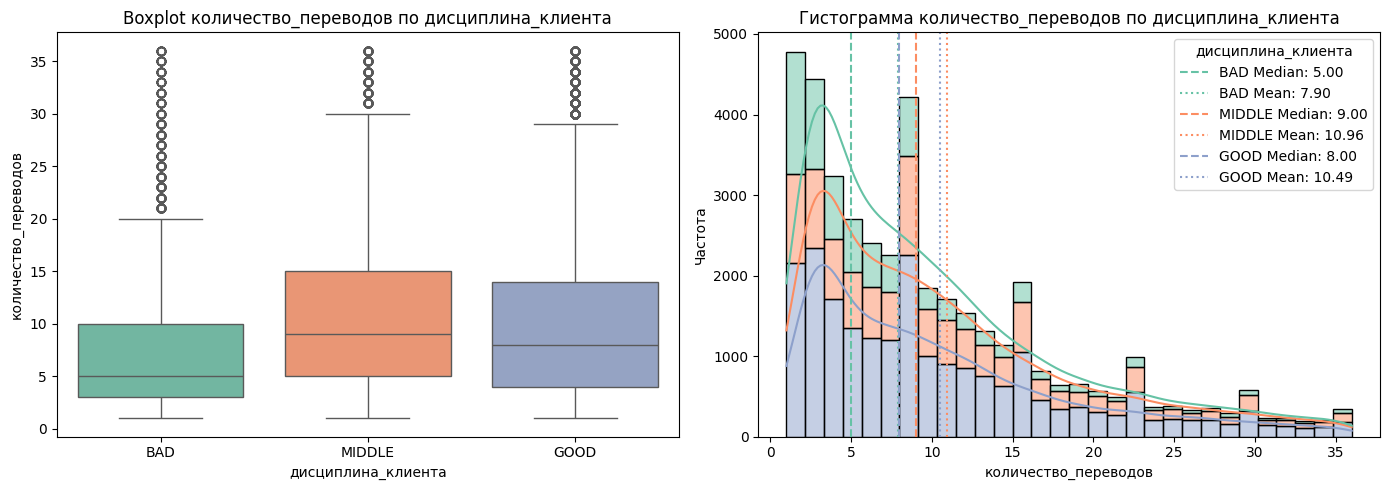

/tmp/ipython-input-2758734103.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df_not_anomals, palette=discipline_colors)


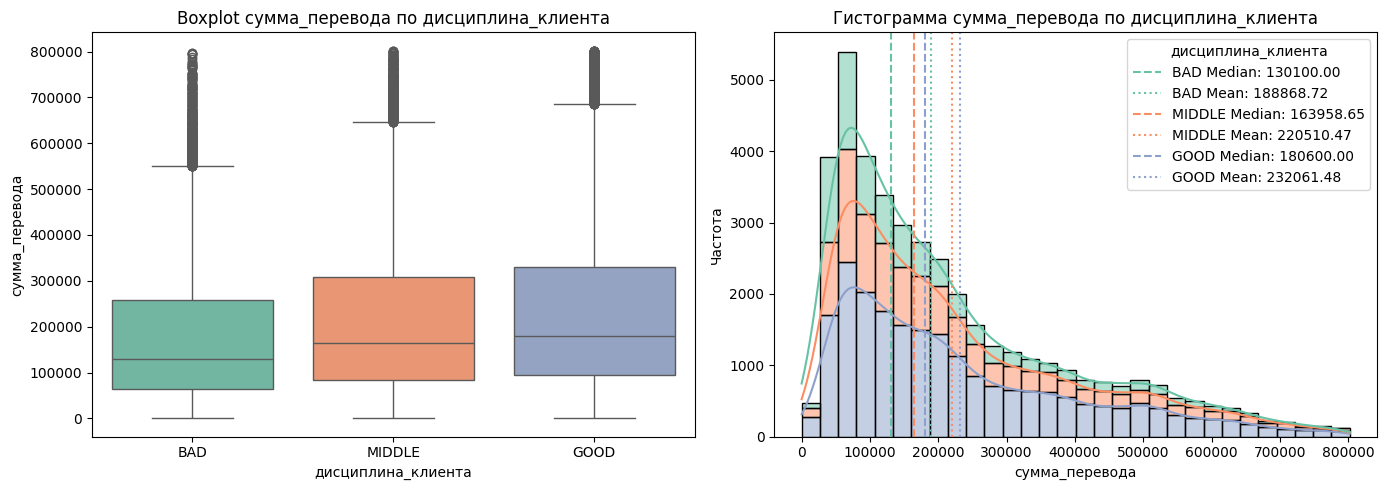

/tmp/ipython-input-2758734103.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df_not_anomals, palette=discipline_colors)


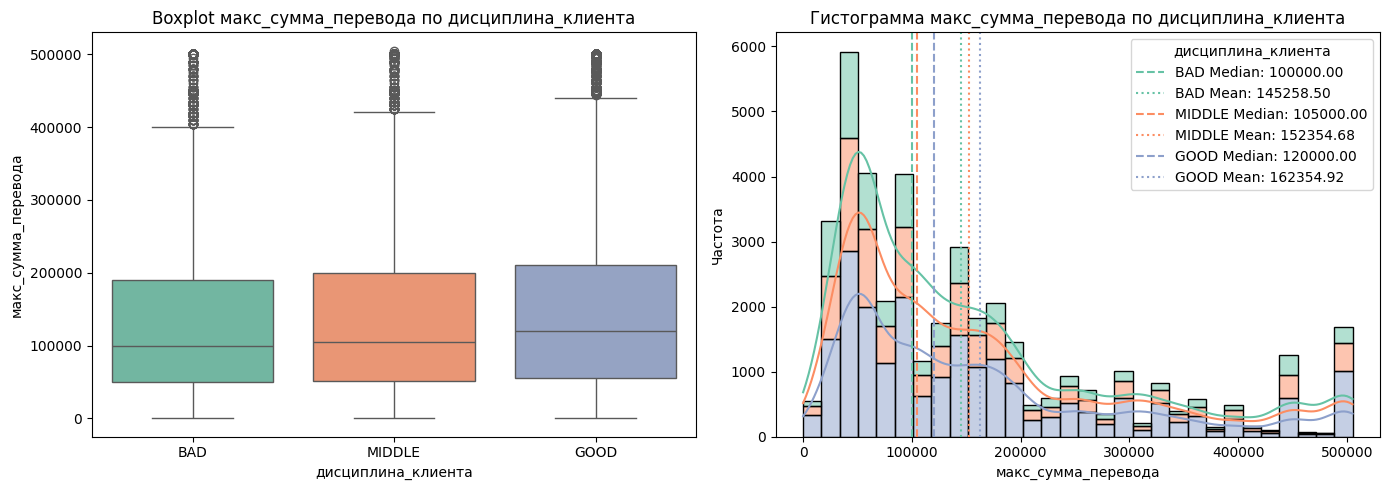

In [ ]:
# построим ящики с усами и гистограммы
target_col = 'дисциплина_клиента'

# Create a dictionary to map discipline to color
discipline_colors = {discipline: sns.color_palette('Set2')[i] for i, discipline in enumerate(df_not_anomals[target_col].unique())}


for col in lst_var_cont:
    plt.figure(figsize=(14,5))

    # --- Boxplot ---
    plt.subplot(1,2,1)
    sns.boxplot(x=target_col, y=col, data=df_not_anomals, palette=discipline_colors)
    plt.title(f'Boxplot {col} по {target_col}', fontsize=12)
    plt.xlabel(target_col)
    plt.ylabel(col)

    # --- Гистограмма с KDE ---
    plt.subplot(1,2,2)
    ax = sns.histplot(
        data=df_not_anomals,
        x=col,
        hue=target_col,
        kde=True,
        bins=30,
        multiple='stack',
        palette=discipline_colors
    )
    plt.title(f'Гистограмма {col} по {target_col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Частота')

    # добавим медианы и средние на гистограммы
    for discipline in df_not_anomals[target_col].unique():
        subset = df_not_anomals[df_not_anomals[target_col] == discipline][col].dropna()
        median_val = subset.median()
        mean_val = subset.mean()

        # медиана
        ax.axvline(median_val, color=discipline_colors[discipline], linestyle='--', label=f'{discipline} Median: {median_val:.2f}')

        # выб среднее
        ax.axvline(mean_val, color=discipline_colors[discipline], linestyle=':', label=f'{discipline} Mean: {mean_val:.2f}')

    plt.legend(title=target_col, loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
# Промежуточные выводы
# на графиках видим, что клиенты с GOOD дисциплиной совершают наибольшее количество переводов,
# а клиенты с BAD дисциплиной наименьшее.
# Клиенты с MIDDLE дисциплиной занимают промежуточное положение по активности между двумя другими.
# По суммам переводов тенденция та же:
# клиенты с GOOD дисциплиной совершают переводы больших сумм, чем две остальные группы.
# Распределение их операций смещено вправо, в область бо́льших значений (приближаясь к 400 000 – 800 000).
# Это свидетельствует о том, что клиенты с хорошей дисциплиной либо нуждаются в крупных переводах,
# либо банк позволяет им оперировать крупными суммами.
# Клиенты с MIDDLE дисциплиной: Занимают промежуточное положение.
# Средняя сумма их переводов выше, чем у группы BAD, но заметно ниже, чем у группы GOOD.


In [ ]:
# Посмотрим графики плотности распределения без гистограмм и выведем на них средние и медианные значения

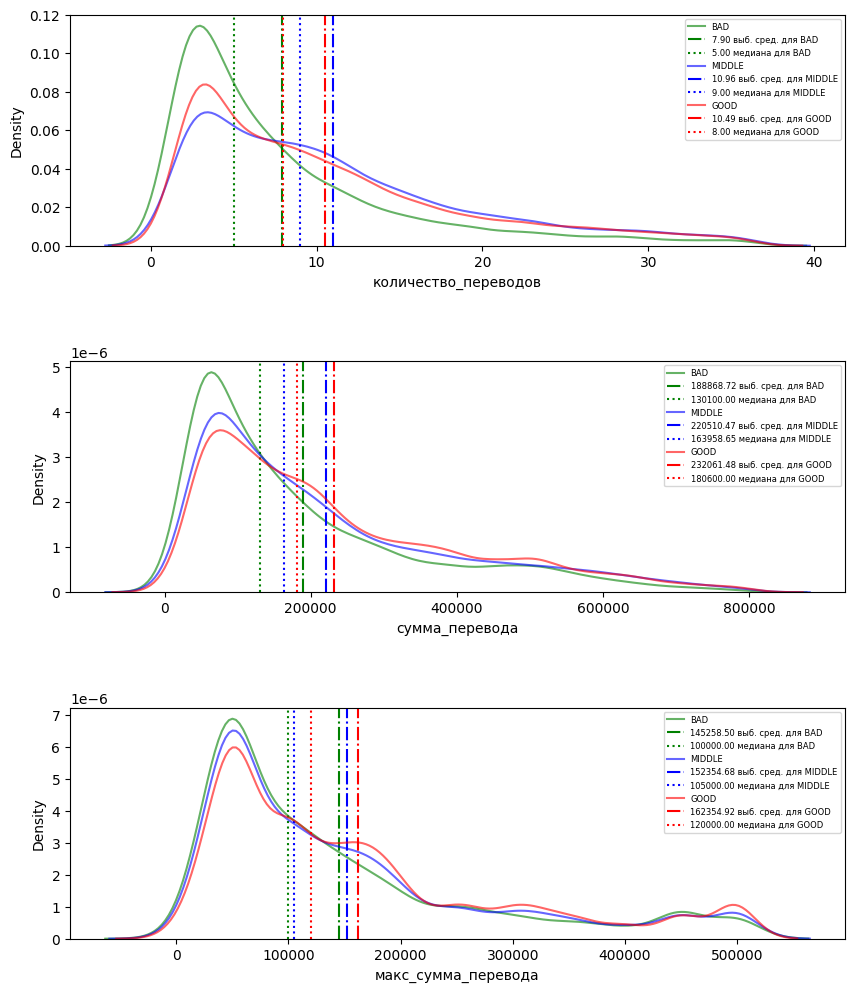

In [ ]:
plt.subplots(3,1, figsize=(10,12), gridspec_kw={'wspace':0.5,
                                               'hspace':0.5} )

dct_color = {'BAD': 'green',
             'MIDDLE': 'blue',
             'GOOD': 'red',
             }

for index_fig, col in enumerate(lst_var_cont, start=1):
    plt.subplot(3,1, index_fig)
    for client_status in df_not_anomals['дисциплина_клиента'].unique():
        ser_temp = df_not_anomals[df_not_anomals['дисциплина_клиента'] == client_status][col]
        ax = sns.kdeplot(ser_temp,
                          color=dct_color.get(client_status),
                          label=f'{client_status}',
                          alpha=0.6)
        ax.axvline(ser_temp.mean(),
                   color=dct_color.get(client_status),
                   linestyle='-.',
                   label=f'{ser_temp.mean():.2f} выб. сред. для {client_status}')
        ax.axvline(ser_temp.median(),
                   color=dct_color.get(client_status),
                   linestyle=':',
                   label=f'{ser_temp.median():.2f} медиана для {client_status}')

        plt.legend(fontsize=6)

In [ ]:
# Наши выводы по боксплотам и гистограммам хорошо видны по плотности распределения:
# Прямая зависимость. Наблюдается четкая прямая связь: чем лучше дисциплина клиента (GOOD),
# тем выше его лимиты, активность и суммы переводов. Чем она хуже (BAD), тем жестче ограничения.
# Управление рисками. Банк использует дисциплину клиента как ключевой фактор для управления рисками:
# GOOD-клиенты: получают максимальные возможности (высокие лимиты, крупные суммы).
# BAD-клиенты: работают в условиях строгих ограничений (низкие лимиты, мелкие суммы).
# Поведенческий паттерн. Надежные клиенты не только имеют доступ к большим суммам,
# но и активнее пользуются услугами банка, совершая больше операций.

## Исследование распределения категориальных признаков в разрезе значений целевого признака `Дисциплина клиентов без просрочки по кредиту`

In [ ]:
# категориальные признаки
lst_var_disc=['дисциплина_клиента', 'тип_переводов', 'география_переводов',
              'география_телефона', 'канал_клиента', 'оператор_связи', 'пол']
# признак возраст рассмотри отдельно

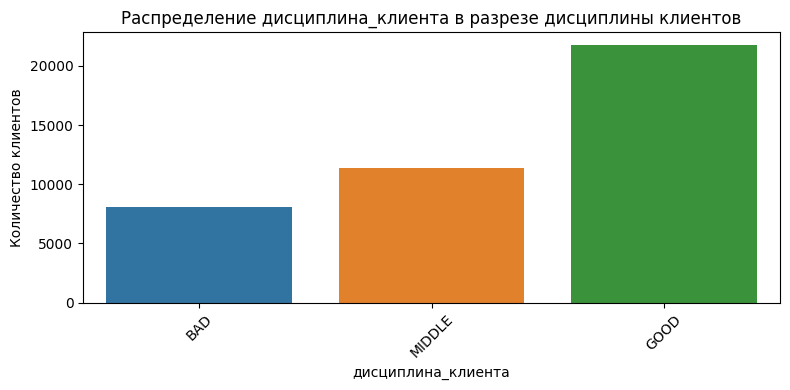

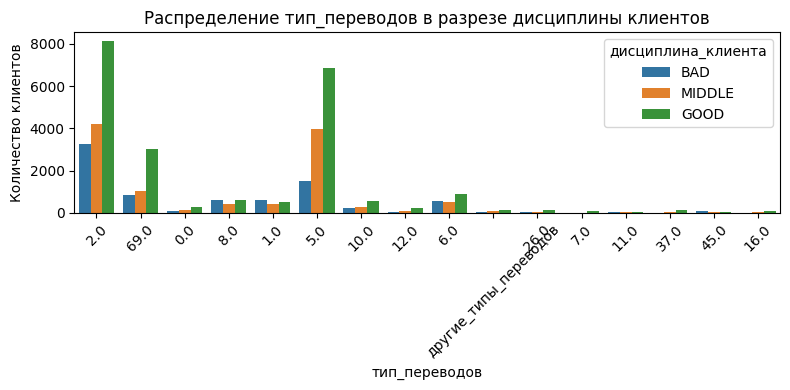

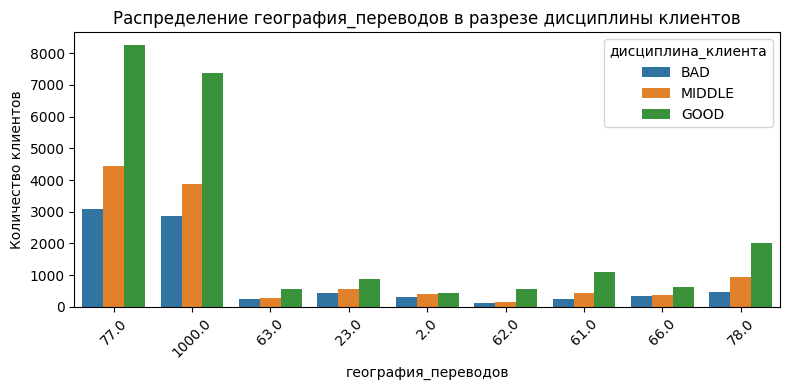

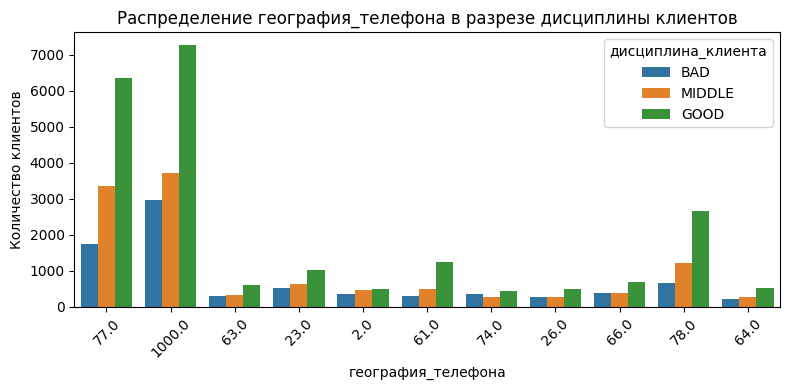

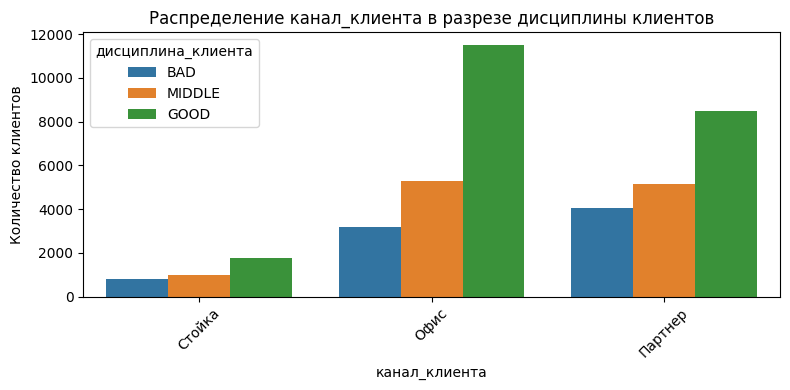

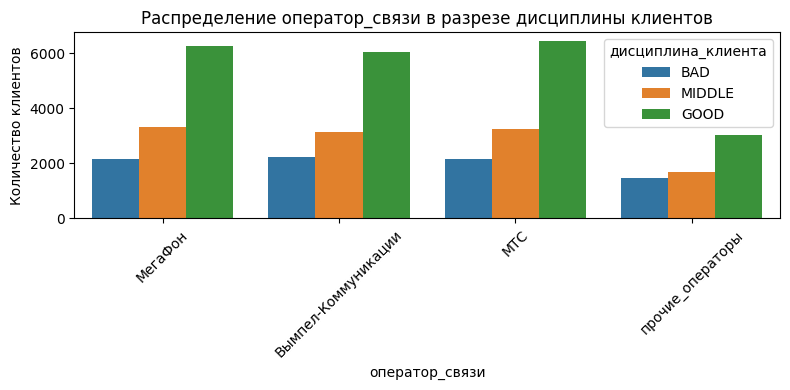

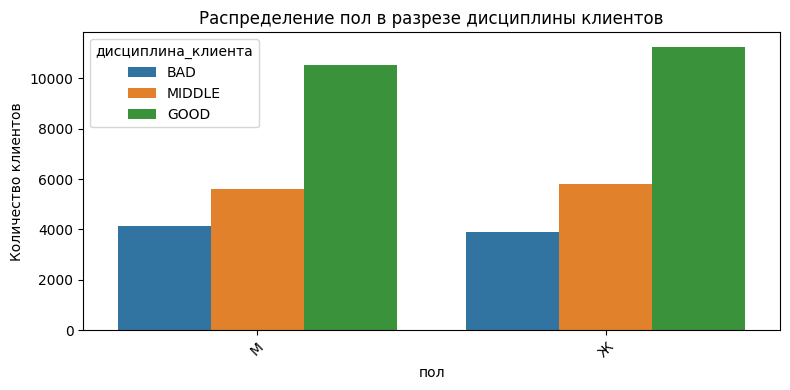

In [ ]:
target = 'дисциплина_клиента'

for col in lst_var_disc:
    plt.figure(figsize=(8,4))
    ax = sns.countplot(data=df_not_anomals, x=col, hue=target)
    plt.title(f'Распределение {col} в разрезе дисциплины клиентов')
    plt.xticks(rotation=45)
    plt.ylabel("Количество клиентов")
    plt.xlabel(col)

    # ax.legend(title="Дисциплина")

    plt.tight_layout()
    plt.show()

In [ ]:
# При анализе графиков распределения категориальных признаков в разрезе значений
# целевого признака 'Дисциплина клиентов без просрочки' по кредиту
# никаких особенных тенденций не прослеживается

In [ ]:
# отдельно рассмотрим признак 'возраст' в разрезе 'дисциплины_клиентов'

In [ ]:
df_not_anomals.groupby('дисциплина_клиента')['возраст_клиента'].describe()

,count,mean,std,min,25%,50%,75%,max
дисциплина_клиента,,,,,,,,
BAD,8042.0,51.864337,10.762862,34.0,43.0,50.0,60.0,83.0
GOOD,21775.0,55.740712,10.825244,33.0,47.0,55.0,64.0,85.0
MIDDLE,11382.0,53.242400,10.839153,34.0,44.0,52.0,61.0,85.0



Количество клиентов по возрастным группам:

возраст_группы
(18, 23]       0
(23, 28]       0
(28, 33]       1
(33, 38]    2689
(38, 43]    5425
(43, 48]    5977
(48, 53]    6457
(53, 58]    5839
(58, 63]    5404
(63, 68]    4512
(68, 73]    3032
(73, 78]    1577
Name: count, dtype: int64


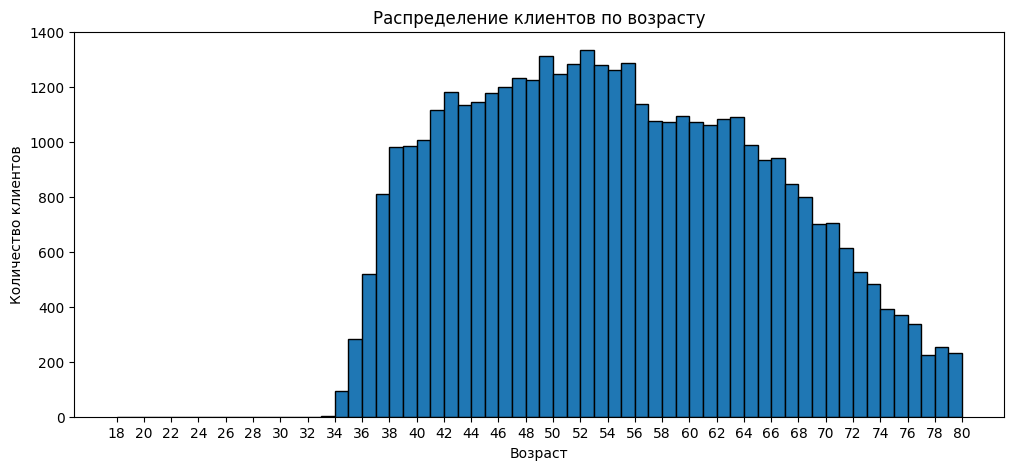

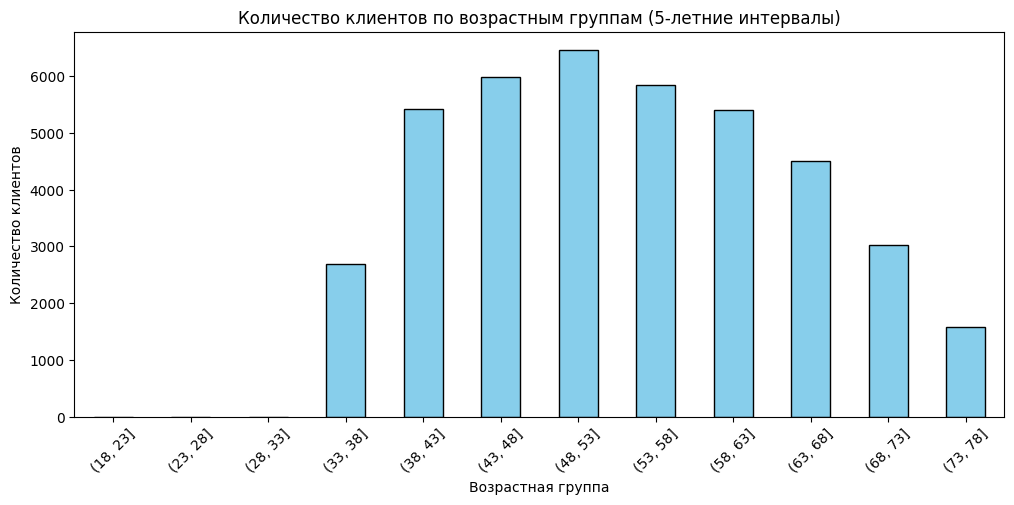

In [ ]:
#  Количество клиентов по возрастным группам (биннинг)
bins = range(18, 81, 5)  # интервалы 18-22, 23-27, ...
df_not_anomals['возраст_группы'] = pd.cut(df_not_anomals['возраст_клиента'], bins=bins)
age_group_counts = df_not_anomals['возраст_группы'].value_counts().sort_index()
print("\nКоличество клиентов по возрастным группам:\n")
print(age_group_counts)


#  Визуализация через гистограмму
plt.figure(figsize=(12,5))
plt.hist(df_not_anomals['возраст_клиента'], bins=range(18, 81), edgecolor='black')
plt.xlabel("Возраст")
plt.ylabel("Количество клиентов")
plt.title("Распределение клиентов по возрасту")
plt.xticks(range(18, 81, 2))
plt.show()

#  Визуализация по возрастным группам (столбчатая диаграмма)
plt.figure(figsize=(12,5))
age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Возрастная группа")
plt.ylabel("Количество клиентов")
plt.title("Количество клиентов по возрастным группам (5-летние интервалы)")
plt.xticks(rotation=45)
plt.show()

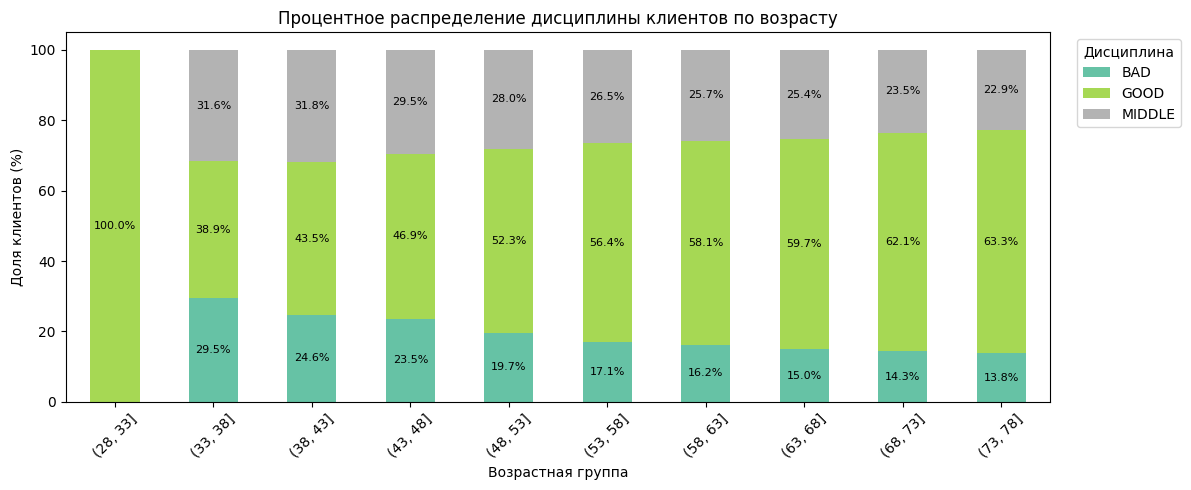

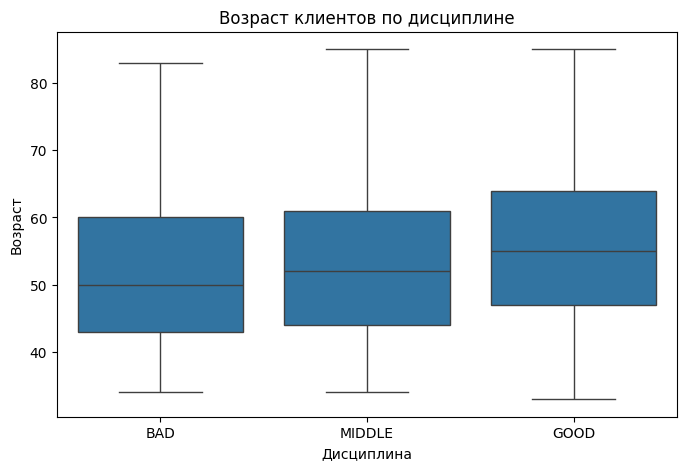

In [ ]:
# нарисуем диаграмму процентное распределение дисциплины клиентов по возрасту
#  barplot с процентами
ctab_pct = pd.crosstab(
    df_not_anomals['возраст_группы'],
    df_not_anomals['дисциплина_клиента'],
    normalize='index'
) * 100  # переводим в проценты

ax = ctab_pct.plot(kind='bar', stacked=True, figsize=(12,5), colormap='Set2')
plt.title("Процентное распределение дисциплины клиентов по возрасту")
plt.xlabel("Возрастная группа")
plt.ylabel("Доля клиентов (%)")
plt.xticks(rotation=45)

# подписи процентов над сегментами
for i, row in enumerate(ctab_pct.values):
    cum_height = 0
    for j, val in enumerate(row):
        if val > 0:  # не пишем нули
            ax.text(
                x=i,
                y=cum_height + val/2,
                s=f"{val:.1f}%",
                ha='center',
                va='center',
                fontsize=8,
                color='black'
            )
        cum_height += val

plt.legend(title="Дисциплина", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

#  Boxplot для распределения возраста по дисциплине
plt.figure(figsize=(8,5))
sns.boxplot(data=df_not_anomals, x='дисциплина_клиента', y='возраст_клиента')
plt.title("Возраст клиентов по дисциплине")
plt.ylabel("Возраст")
plt.xlabel("Дисциплина")
plt.show()


In [ ]:
# количество клиентов в бинах
# на первом графике сразу видно что первый столбик непоказателен, тк там только 1 клиент(аномалия)
bins = range(18, 81, 5)  # 18-22, 23-27, ...
df_not_anomals['возраст_группы'] = pd.cut(df_not_anomals['возраст_клиента'], bins=bins)

df_not_anomals['возраст_группы'].value_counts().sort_index()

,count
возраст_группы,
"(18, 23]",0
"(23, 28]",0
"(28, 33]",1
"(33, 38]",2689
"(38, 43]",5425
"(43, 48]",5977
"(48, 53]",6457
"(53, 58]",5839
"(58, 63]",5404


In [ ]:
# Таблица описательной статистики по возрасту
age_stats = df_not_anomals.groupby('дисциплина_клиента')['возраст_клиента'].describe()
print("Описательная статистика возраста по дисциплине:\n")
print(age_stats.round(1))

Описательная статистика возраста по дисциплине:

                      count  mean   std   min   25%   50%   75%   max
дисциплина_клиента                                                   
BAD                  8042.0  51.9  10.8  34.0  43.0  50.0  60.0  83.0
GOOD                21775.0  55.7  10.8  33.0  47.0  55.0  64.0  85.0
MIDDLE              11382.0  53.2  10.8  34.0  44.0  52.0  61.0  85.0


In [ ]:
# Промежуточные выводы по таблице: средний возраст хорошего клиента выше, чем у двух остальных категорий
# мин и макс возраста практически не отличаются

In [ ]:
# Промежуточные выводы по возрастным группам
# Первый график показывает доли клиентов разных категорий дисциплины (BAD, MIDDLE, GOOD) в каждой возрастной группе
# Общая тенденция - чем старше клиенты, тем больше среди них клиентов с GOOD дисциплиной
# В возрастной категории 33-38 количество клиентов по дисциплинам распределены равномерно.
# Далее прослеживается тенденция: с увеличением возраста увеличивается кол-во клиентов с хорошей и средней дисциплиной,
# причем доля клиентов GOOD растет сильнее, чем MIDDLE.
# Группа 28-33 года требует дополнительного изучения: необходимо выяснить,
# почему в этой потенциально важной когорте так мало клиентов банка.
# Возможно, это связано с продуктом (например, банк не продвигает кредиты среди молодежи)
# или с особенностями данных (выборка за конкретный период).

In [ ]:
df_not_anomals.head(2)

,идентификатор,дата_рождения,дисциплина_клиента,количество_переводов,тип_переводов,география_переводов,география_телефона,сумма_перевода,макс_сумма_перевода,канал_клиента,оператор_связи,пол,возраст_клиента,возраст_группы
2,1782539,1957-04-29,BAD,3.0,2.0,77.0,77.0,175150.0,135000.0,Стойка,МегаФон,М,68,"(63, 68]"
9,7369177,1964-12-17,BAD,9.0,2.0,77.0,77.0,62310.0,38000.0,Офис,Вымпел-Коммуникации,Ж,60,"(58, 63]"


## Сформулируем и проверим гипотезы:
- H_0 средний возраст клиентов с GOOD дисциплиной статичестически выше, чем у клиентов с BAD дисциплиной
- H_1 средний возраст клиентов с GOOD и BAD дисциплиной  не отличается


In [ ]:
# сделаем выборки по возрасту и дисциплине
age_good = df_not_anomals[df_not_anomals['дисциплина_клиента']=='GOOD']['возраст_клиента']
age_bad  = df_not_anomals[df_not_anomals['дисциплина_клиента']=='BAD']['возраст_клиента']

In [ ]:
# посчитаем коэффициенты Шапиро и проверим выборки на нормальность распределения
print(stats.shapiro(age_good))
print(stats.shapiro(age_bad))

ShapiroResult(statistic=np.float64(0.9814434379981276), pvalue=np.float64(1.1013574293000119e-45))
ShapiroResult(statistic=np.float64(0.9623745968906916), pvalue=np.float64(2.2573542070557937e-41))


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21775.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8042.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# p-value << 0.05, значит нулевая гипотеза нормальности отклоняется.
# То есть распределение возраста в обеих группах не является нормальным.
# Вывод: обе рассматриваемые случайные величины не подчиняются закону о нормальном распределению
# Гипотезы о нормальном распределении отвергаем для обоих случайных величин.
# В этом случае для проверки гипотезы о разнице в возрасте
# следует воспользоваться либо критерием Манна-Уитни

In [ ]:
# Mann-Whitney (односторонний: GOOD > BAD)
u_stat, p_value = stats.mannwhitneyu(age_good, age_bad, alternative='greater')


print(f"p-value: {p_value}")

p-value: 7.579503018434257e-167


In [ ]:
# Выводы
# p-value << 0.05 — очень сильное статистическое доказательство.
# Следовательно, средний возраст клиентов с дисциплиной GOOD действительно выше, чем у клиентов с дисциплиной BAD.

In [ ]:
# выбираем  дисциплину и возраст и посмотрим их средние и медианы в таблице
# выбираем только BAD и GOOD
df_age_disc = df_not_anomals[df_not_anomals['дисциплина_клиента'].isin(['BAD','GOOD'])][['дисциплина_клиента', 'возраст_клиента']]

# проходим по каждой дисциплине
for disc in ['BAD', 'GOOD']:
    subset = df_age_disc[df_age_disc['дисциплина_клиента']==disc]
    mean_val = round(subset['возраст_клиента'].mean(), 2)
    median_val = subset['возраст_клиента'].median()
    print(f"Дисциплина: {disc}")
    print(f"  Выборочное среднее возраста: {mean_val}")
    print(f"  Медиана возраста: {median_val}\n")

Дисциплина: BAD
  Выборочное среднее возраста: 51.86
  Медиана возраста: 50.0

Дисциплина: GOOD
  Выборочное среднее возраста: 55.74
  Медиана возраста: 55.0



In [ ]:
# и на графиках

/tmp/ipython-input-3190811452.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


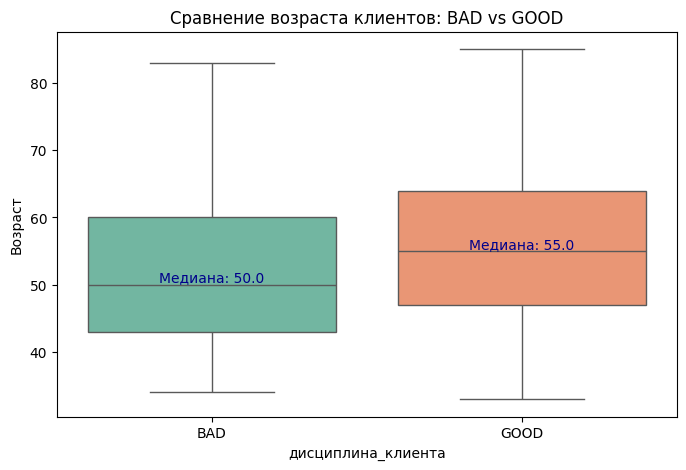

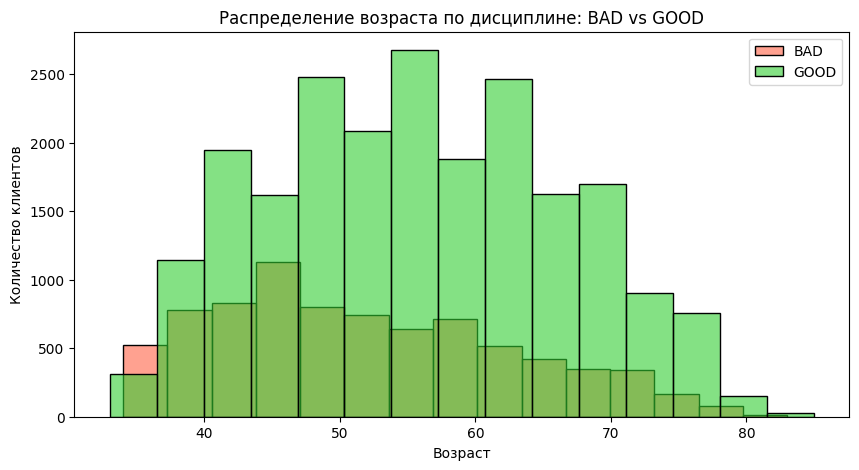

In [ ]:
# фильтруем только BAD и GOOD
df_compare = df_not_anomals[df_not_anomals['дисциплина_клиента'].isin(['BAD','GOOD'])]

# Boxplot
plt.figure(figsize=(8,5))
ax = sns.boxplot(
    data=df_compare,
    x='дисциплина_клиента',
    y='возраст_клиента',
    palette='Set2',
    showfliers=True,
    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.7)
)

# подписи медиан
for i, group in enumerate(['BAD','GOOD']):
    median_val = df_compare[df_compare['дисциплина_клиента']==group]['возраст_клиента'].median()
    ax.text(
        x=i,
        y=median_val,
        s=f"Медиана: {median_val}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='darkblue'
    )

plt.title("Сравнение возраста клиентов: BAD vs GOOD")
plt.ylabel("Возраст")
plt.show()

# Гистограммы
plt.figure(figsize=(10,5))
sns.histplot(df_compare[df_compare['дисциплина_клиента']=='BAD']['возраст_клиента'],
             color='tomato', label='BAD', kde=False, bins=15, alpha=0.6)
sns.histplot(df_compare[df_compare['дисциплина_клиента']=='GOOD']['возраст_клиента'],
             color='limegreen', label='GOOD', kde=False, bins=15, alpha=0.6)

plt.xlabel("Возраст")
plt.ylabel("Количество клиентов")
plt.title("Распределение возраста по дисциплине: BAD vs GOOD")
plt.legend()
plt.show()


In [ ]:
# Выводы по гипотезам:
# принимаем гипотезу H_0: средний возраст клиентов с GOOD дисциплиной статичестически выше,
# чем у клиентов с BAD дисциплиной

In [ ]:
# посмотрим матрицу корреляции

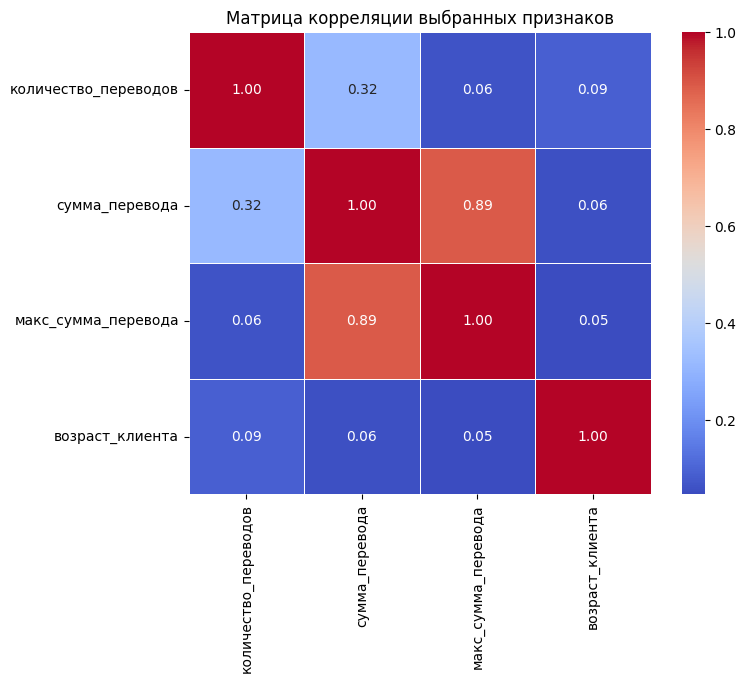

In [ ]:
# Выбираем только числовые столбцы
numeric_cols = [
    'количество_переводов',
    'сумма_перевода',
    'макс_сумма_перевода',
    'возраст_клиента']

#  Корреляция
df_numeric = df_not_anomals[numeric_cols]

# рассчитываем корреляцию
corr_matrix = df_numeric.corr(method='pearson')

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=0.5
)
plt.title("Матрица корреляции выбранных признаков")
plt.show()

In [ ]:
# Выводы по матрице корреляции:
# четкая прямая взаимосвязь прослеживается только между признаками: 'количество переводов' и 'макс сумма переводов':
# чем больше суммы переводов, тем больше и максимальные суммы переводов
# так же можем увидеть, что взаимосвязь между возрастом клиента и кол-вом или суммой переводов не имеют линейной связи

In [ ]:
# выгрузим обработанные данные в файл для построения дашборда
df_not_anomals.to_csv('df_not_anomals.csv', index=False, encoding='utf-8-sig')

## В разрезе значений целевого признака составить портреты клиентов платежной системы.


- Портрет клиента с дисциплиной BAD (Высокий риск)
    1. Возраст: Преимущественно молодые клиенты (18-43 лет).
    2. Финансовое поведение:
    Суммы операций: Совершает мелкие переводы. Банк строго лимитирует максимальную сумму.
    Активность: Низкая. Количество переводов невелико.
    Дисциплина: Имеет просрочки по кредитным обязательствам.
    3. Канал привлечения: чаще всего приходят чере партнеров или офисы банка
    4. Ключевая характеристика:
    «Неактивный новичок» или «Проблемный заёмщик». Низкие лимиты и мало операций могут быть как причиной (банк ограничил), так и следствием (клиент не нуждается в большем) плохой дисциплины.

- Портрет клиента с дисциплиной MIDDLE (Умеренный риск)
    1. Возраст: Средний (40-50 лет). "Золотая середина".
    2. Финансовое поведение:
    Суммы операций: Средние переводы. Лимиты банка выше, чем у группы BAD, но ниже, чем у GOOD.
    Активность: Умеренная. Регулярно пользуется платёжными услугами.
    Дисциплина: В целом исправный плательщик, но, возможно, допускал единичные просрочки в прошлом.
    3. Канал привлечения: чаще всего приходят через партнеров или офисы банка
    4. Ключевая характеристика:
    «Стабильный середнячок». Банк доверяет им в умеренной степени. Это целевая группа для программ по улучшению кредитной истории и перевода в категорию GOOD.

- Портрет клиента с дисциплиной GOOD (Низкий риск)
    1. Возраст: Зрелые и старшие клиенты (50+ лет)
    2. Финансовое поведение:
    Суммы операций: Совершает крупные переводы. Банк устанавливает для них максимальные лимиты.
    Активность: Высокая. Активно управляет финансами через банк, совершает много операций.
    Дисциплина: Безупречная. Не имеет просрочек.
    3. Канал привлечения: преимущественно офис банка
    4. Ключевая характеристика:
    «Надёжный активный» или «Премиальный клиент». Это самый желательный тип клиентов. Они приносят банку доход за счёт большого оборота средств и не создают затрат на взыскание долгов. Получают лучшие условия и сервис.



## Выводы по этапу исследовательского анализа

На этапе исследовательского анализа были проведены следующие  работы:
-  Исследовано распределение числовых признаков в разрезе значений целевого признака `Дисциплина клиентов без просрочки по кредиту`
    -  клиенты с GOOD дисциплиной совершают наибольшее количество переводов и средняя сумма перевода у них выше, чем у двух других категорий;  
    - Наблюдается четкая прямая связь: чем лучше дисциплина клиента (GOOD), тем выше его лимиты, активность и суммы переводов. Чем она хуже (BAD), тем жестче ограничения;
    
- Исследовано распределение категориальных признаков в разрезе значений целевого признака `Дисциплина клиентов без просрочки по кредиту`, признак `возраст` был исследован отдельно
    -  При анализе графиков распределения категориальных признаков в разрезе значений  целевого признака 'Дисциплина клиентов без просрочки' по кредиту никаких особенных тенденций не прослеживается;
    - анализ распределения по `возрасту` показывает, что среди старших клиентов доля с дисциплиной GOOD выше, чем среди молодых;

- Были сформулированы и проверены гипотезы:
    - H_0 средний возраст клиентов с GOOD дисциплиной статичестически выше, чем у клиентов с BAD дисциплиной;  
    - H_1 средний возраст клиентов с GOOD и BAD дисциплиной не отличается;  
    - В результате проверок приняли гипотезу H_0  

- Постороили и пронализировали матрицу корреляции числовых признаков  

- В разрезе значений целевого признака `Дисциплина клиентов без просрочки по кредиту` составлены портреты клиентов платежной системы


# Общие выводы по проекту



- Аналитическая задача выполнена полностью.

- Сформированы портреты клиентов по дисциплине и ключевым показателям.

- Полученные результаты могут быть использованы для:

    - сегментации клиентов,

    - таргетирования маркетинговых кампаний,

    - управления рисками по кредитам.

#